# Clustering

## Introduction

Grouping cells based on the similarity of their expression profiles allows us to identify cell types and states, as well as infer differences between groups. This is done either via __clustering__ or __community detection__. 

__Unsupervised clustering__ is useful in many different applications and has been widely studied in machine learning. Some of the most popular approaches are __hierarchical clustering__ and __k-means clustering__. These methods compute a __distance metric__ between cells (often based on a low-dimensional representation, such as PCA, tSNE or UMAP), and then iteratively group cells together based on these distances.

__Community detection__ methods (also referred to as 'graph-based clustering') partition the __neighbor graph__. The neighbor graph treats each cell as a node, with edges connecting each node to its _k_ nearest neighbors (based on similar distance metrics described above). The graph is then partitioned into modules based on these connectivities. These methods are typically faster than other clustering methods with similar effectiveness.  

One thing virtually all clustering or community detection methods have in common is some flavor of a __resolution parameter__. This parameter controls how fine- or coarse-grained the inferred clusters are. This parameter can have major effects on your results! We'll explore this in more detail below.

Here, we'll explore __k-means clustering__ and the graph-based __louvain clustering__ method. 

## Load data

In [1]:
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
%matplotlib inline

adata = sc.read('../data/brain_embeddings.h5ad')

## k-means

In [_k_-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), the goal is to partition _N_ cells into _k_
different clusters. This is done in an iterative manner, cluster centers are
assigned and each cell is assigned to its nearest cluster:

![](../figures/k-means.png)

Let's try this out on the umap representation of our dataset. Scanpy doesn't include a method for k-means clustering, so we'll extract the umap coordinates that we calculated earlier and use `scikit-learn` for this task instead.

... storing 'kmeans' as categorical


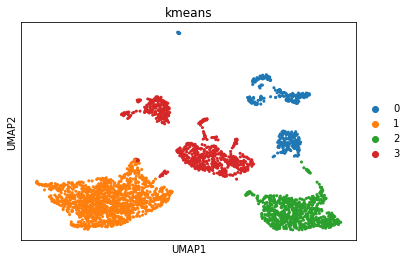

In [14]:
umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

## Evaluating clustering 

Intuitively, we can see from the plot that our value of _k_ (the number of clusters) is probably too low. 

This dataset has "ground truth" cell type labels available. We can use these to assess our cluster labels a bit more rigorously using the __adjusted Rand index__. This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance. 

In [17]:
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.85


### Exercise  

Try rerunning k-means clustering with several different values of _k_. Does this improve the Rand index? 

In [ ]:
kmeans = KMeans(n_clusters= , random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

## Graph-based methods

Graph-based methods attempt to partition a pre-computed __neighhbor graph__ into modules (i.e., groups / clusters of cells) based on their connectivity. Currently, the most widely used graph-based methods for single cell data are variants of the __louvain__ algorithm. The intuition behind the louvain algorithm is that it looks for areas of the neighbor graph that are more densely connected than expected (based on the overall connectivity in the graph).

<img width=500 src='../figures/graph_network.jpg'>


## Exercise 

1. Use the scanpy function `sc.tl.louvain` to compute the graph-based cluster labels for our dataset. Visualize your results on the UMAP plot. What is the Rand index compared to the ground-truth cell types?

2. Repeat this with several different values for the `resolution` parameter. How does this effect your results? 

<p>
<details>
<summary><h3>Solution</h3></summary>
<code style=display:block;white-space:pre-wrap>sc.tl.louvain(adata)
sc.pl.umap(adata, color='louvain')
rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['louvain'])
print('The rand index is ', round(rand_index, 2))</code>
<p/>    
The low rand index with the default resolution parameter is quite low (0.34), but this increases to 0.9 when we set <code>resolution=0.1</code>.  
</details>
</p>

In [ ]:
help(sc.tl.louvain)
help(sc.pl.umap)
help(adjusted_rand_score)


## Exercise

In this dataset, we're lucky enough to have carefully curated cell type labels to help guide our choice of clustering method and parameters. However, we may not always have this ground truth available; deciding what constitutes a reasonable clustering result is a judgement call. In some cases, this is largely dependent upon how choose to define "cell type." 

1. What do you think is a reasonable definition of "cell type?" Why? How could this guide your choice of cluster parameters? Brainstorm independently for 2 minutes, then share with your neighbor. Do you agree? 


2. Use the adjusted Rand index to compare the labels from k-means clustering to the labels from louvain clustering. How similar are they?

In [ ]:
help(adjusted_rand_score)



## Advanced exercise 

So far, we've explored how the choice of resolution parameter influences the results we get from clustering. However, these clustering algorithms are also downstream dependents on the results of umap (k-means and louvain) and the neighbor graph (louvain). These methods also have parameter choices that can influence our results. 

Try recalculating `sc.tl.umap` and `sc.pp.neighbors` under different parameter values. Then recalculate clusters with your favorite method. How much did this change the results?  

In [ ]:
help(sc.pp.neighbors)
help(sc.tl.umap)



## Advanced exercise

Sometimes, we may want to look at clusters within a given tissue or cell type designation. This can surface interesting heterogeneity between subpopulations, although it can also make our results more noisy. 

Use the snippet below to subset the data to cells from the cerebellum and recalculate the neighbor graph and umap embedding for this subset. Then rerun your favorite clustering method on these cells. What do you observe? Do you think these subpopulations are based on real biological variation or primarily due to noise? How can you tell?

In [30]:
cerebellum = adata[adata.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

# your favorite clustering method here


Let's finalize our clusters and write to file

In [31]:
sc.tl.louvain(adata, resolution=0.1)
adata.write('../data/brain_clusters.h5ad')